# Build and Evaluate a Linear Risk model


Building a risk score model for retinopathy in diabetes patients using logistic regression.

Steps 

- Data preprocessing
  - Log transformations
  - Standardization
- Basic Risk Models
  - Logistic Regression
  - C-index
  - Interactions Terms
  
### Diabetic Retinopathy
Retinopathy is an eye condition that causes changes to the blood vessels in the part of the eye called the retina.
This often leads to vision changes or blindness.
Diabetic patients are known to be at high risk for retinopathy. 
    
### Logistic Regression    
Logistic regression is used for predicting the probability of a binary outcome. In our case, this would be the probability of having or not having diabetic retinopathy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<a name='2'></a>
## 1. Load Data

In [2]:
#X_data and y_data are generated files taken from Ai in medicine course
X = pd.read_csv('X_data.csv',index_col=0)
y_df = pd.read_csv('y_data.csv',index_col=0)
y = y_df['y']

`X` and `y` are Pandas DataFrames that hold the data for 6,000 diabetic patients. 

<a name='3'></a>
##  2. Explore the Dataset

The features (`X`) include the following fields:
* Age: (years)
* Systolic_BP: Systolic blood pressure (mmHg)
* Diastolic_BP: Diastolic blood pressure (mmHg)
* Cholesterol: (mg/DL)

In [3]:
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


The target (`y`) is an indicator of whether or not the patient developed retinopathy.

* y = 1 : patient has retinopathy.
* y = 0 : patient does not have retinopathy.

In [4]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: y, dtype: float64

split the data into train and test sets using a 75/25 split.

For this, we can use the built in function provided by sklearn library.  See the documentation for [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

Plot the histograms of each column of `X_train` below: 

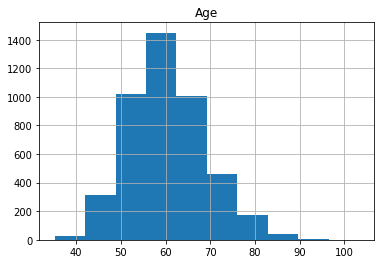

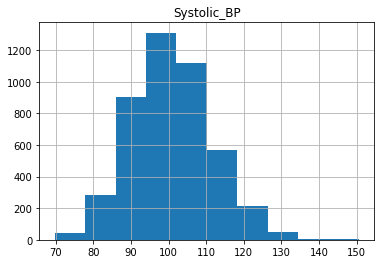

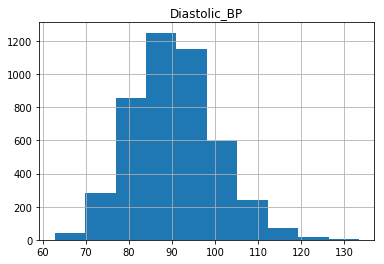

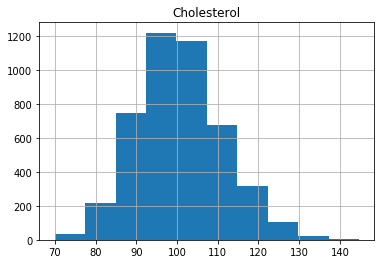

In [7]:
for col in X.columns:
    X_train_raw.loc[:, col].hist()
    plt.title(col)
    plt.show()

As we can see, the distributions have a generally bell shaped distribution, but with slight rightward skew.

We can transform our data to be closer to a normal distribution by removing the skew. One way to remove the skew is by applying the log function to the data.

Let's plot the log of the feature variables to see that it produces the desired effect.

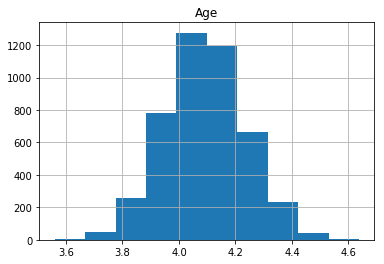

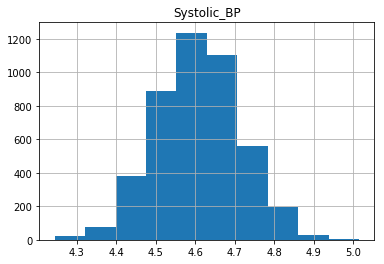

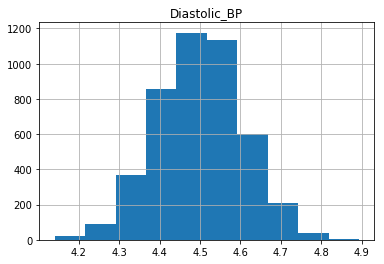

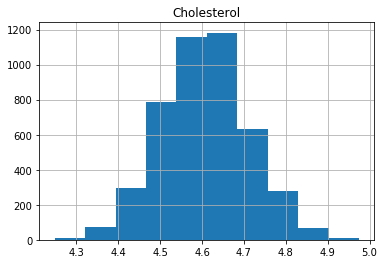

In [8]:
for col in X_train_raw.columns:
    np.log(X_train_raw.loc[:, col]).hist()
    plt.title(col)
    plt.show()

We can see that the data is more symmetric after taking the log.

<a name='4'></a>
## 3. Mean-Normalize the Data

Let's now transform our data so that the distributions are closer to standard normal distributions.

standardizes the distribution so that for each data point $x$,
$$\overline{x} = \frac{x - mean(x)}{std(x)}$$
* Pretend that the test data is "unseen" data. 
    * This implies that it is unavailable to us for the purpose of preparing our data, and so we do not want to consider it when evaluating the mean and standard deviation that we use in the above equation. Instead we want to calculate these values using the training data alone, but then use them for standardizing both the training and the test data.

In [9]:
def make_standard_normal(df_train, df_test):
    """
    Args:
      df_train (dataframe): unnormalized training data.
      df_test (dataframe): unnormalized test data.
  
    Returns:
      df_train_normalized (dateframe): normalized training data.
      df_test_normalized (dataframe): normalized test data.
    """
    
    df_train_unskewed = np.log(df_train)
    df_test_unskewed = np.log(df_test)
    
    mean = df_train_unskewed.mean(axis=0)
    stdev = df_train_unskewed.std(axis=0,ddof=1)
    
    df_train_standardized = (df_train_unskewed - mean)/stdev
    
    df_test_standardized = (df_test_unskewed - mean)/stdev
    
    return df_train_standardized, df_test_standardized

#### Transform training and test data 
Use the function to make the data distribution closer to a standard normal distribution.

In [10]:
X_train, X_test = make_standard_normal(X_train_raw, X_test_raw)

After transforming the training and test sets, we'll expect the training set to be centered at zero with a standard deviation of $1$.

We will avoid observing the test set during model training in order to avoid biasing the model training process, but let's have a look at the distributions of the transformed training data.

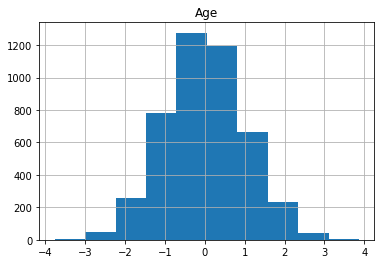

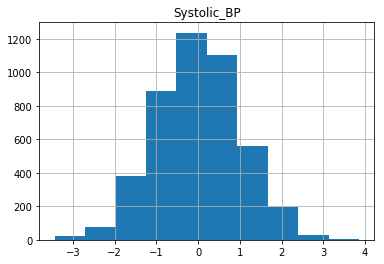

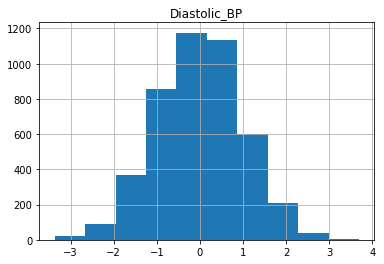

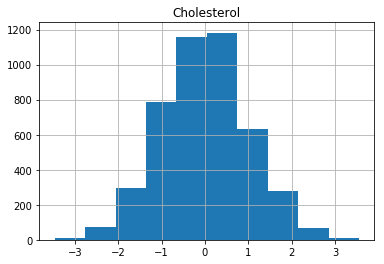

In [11]:
for col in X_train.columns:
    X_train[col].hist()
    plt.title(col)
    plt.show()

<a name='5'></a>
## 4. Build the Model

Now we are ready to build the risk model by training logistic regression with our data.


In [12]:
def lr_model(X_train, y_train):
    
    from sklearn.linear_model import LogisticRegression
    
    model = LogisticRegression(solver='lbfgs')
    
    model.fit(X_train,y_train)
    
    return model

In [13]:
model_X = lr_model(X_train, y_train)

<a name='6'></a>
## 5. Evaluate the Model Using the C-index

Now that we have a model, we need to evaluate it. We'll do this using the c-index. 
* The c-index measures the discriminatory power of a risk score. 
* Intuitively, a higher c-index indicates that the model's prediction is in agreement with the actual outcomes of a pair of patients.
* The formula for the c-index is

$$ \mbox{cindex} = \frac{\mbox{concordant} + 0.5 \times \mbox{ties}}{\mbox{permissible}} $$

* A permissible pair is a pair of patients who have different outcomes.
* A concordant pair is a permissible pair in which the patient with the higher risk score also has the worse outcome.
* A tie is a permissible pair where the patients have the same risk score.


In [14]:
def cindex(y_true, scores):
    '''

    Input:
    y_true (np.array): a 1-D array of true binary outcomes (values of zero or one)
        0: patient does not get the disease
        1: patient does get the disease
    scores (np.array): a 1-D array of corresponding risk scores output by the model

    Output:
    c_index (float): (concordant pairs + 0.5*ties) / number of permissible pairs
    '''
    n = len(y_true)
    assert len(scores) == n

    concordant = 0
    permissible = 0
    ties = 0
    
    for i in range(n):
        for j in range (i+1, n): 
            
            # Check if the pair is permissible (the patient outcomes are different)
            if y_true[i]!=y_true[j]:
                # Count the pair if it's permissible
                permissible +=1

                # For permissible pairs, check if they are concordant or are ties

                # check for ties in the score
                if scores[i]==scores[j]:
                    # count the tie
                    ties+=1
                    # if it's a tie, we don't need to check patient outcomes, continue to the top of the for loop.
                    continue

                # case 1: patient i doesn't get the disease, patient j does
                if y_true[i] == 0 and y_true[j] == 1:
                    # Check if patient i has a lower risk score than patient j
                    if scores[i]<scores[j]:
                        # count the concordant pair
                        concordant+=1
                    # Otherwise if patient i has a higher risk score, it's not a concordant pair.
                    # Already checked for ties earlier

                # case 2: patient i gets the disease, patient j does not
                if y_true[i]==1 and y_true[j] == 0:
                    # Check if patient i has a higher risk score than patient j
                    if scores[i]>scores[j]:
                        #count the concordant pair
                        concordant+=1
                    # Otherwise if patient i has a lower risk score, it's not a concordant pair.
                    # We already checked for ties earlier

    # calculate the c-index using the count of permissible pairs, concordant pairs, and tied pairs.
    c_index = (concordant+(0.5*ties))/permissible
    
    return c_index

<a name='7'></a>
## 6. Evaluate the Model on the Test Set

Now, you can evaluate your trained model on the test set.  

To get the predicted probabilities, we use the `predict_proba` method. This method will return the result from the model *before* it is converted to a binary 0 or 1. For each input case, it returns an array of two values which represent the probabilities for both the negative case (patient does not get the disease) and positive case (patient the gets the disease). 

In [15]:
scores = model_X.predict_proba(X_test)[:, 1]
c_index_X_test = cindex(y_test.values, scores)
print(f"c-index on test set is {c_index_X_test:.4f}")

c-index on test set is 0.8182


Let's plot the coefficients to see which variables (patient features) are having the most effect. You can access the model coefficients by using `model.coef_`

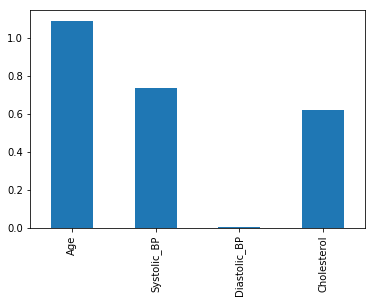

In [16]:
coeffs = pd.DataFrame(data = model_X.coef_, columns = X_train.columns)
coeffs.T.plot.bar(legend=None);

<a name='8'></a>
## 7. Improve the Model

You can try to improve your model by including interaction terms. 
* An interaction term is the product of two variables. 
    * For example, if we have data 
    $$ x = [x_1, x_2]$$
    * We could add the product so that:
    $$ \hat{x} = [x_1, x_2, x_1*x_2]$$
    

In [17]:
def add_interactions(X):
    """
    Add interaction terms between columns to dataframe.

    Args:
    X (dataframe): Original data

    Returns:
    X_int (dataframe): Original data with interaction terms appended. 
    """
    features = X.columns
    m = len(features)
    X_int = X.copy(deep=True)

    # 'i' loops through all features in the original dataframe X
    for i in range(m):
        
        # get the name of feature 'i'
        feature_i_name = features[i]
        
        # get the data for feature 'i'
        feature_i_data = X[feature_i_name]
        
        # choose the index of column 'j' to be greater than column i
        for j in range (i+1, m):
            
            # get the name of feature 'j'
            feature_j_name = features[j]
            
            # get the data for feature j'
            feature_j_data = X[feature_j_name]
            
            # create the name of the interaction feature by combining both names
            # example: "apple" and "orange" are combined to be "apple_x_orange"
            feature_i_j_name = f"{feature_i_name}_x_{feature_j_name}"
            
            # Multiply the data for feature 'i' and feature 'j'
            # store the result as a column in dataframe X_int
            X_int[feature_i_j_name] = X_int[feature_i_name] * X_int[feature_j_name]
        

    return X_int

In [18]:
print("Original Data")
print(X_train.loc[:, ['Age', 'Systolic_BP']].head())
print("Data w/ Interactions")
print(add_interactions(X_train.loc[:, ['Age', 'Systolic_BP']].head()))

Original Data
           Age  Systolic_BP
1824 -0.912451    -0.068019
253  -0.302039     1.719538
1114  2.576274     0.155962
3220  1.163621    -2.033931
2108 -0.446238    -0.054554
Data w/ Interactions
           Age  Systolic_BP  Age_x_Systolic_BP
1824 -0.912451    -0.068019           0.062064
253  -0.302039     1.719538          -0.519367
1114  2.576274     0.155962           0.401800
3220  1.163621    -2.033931          -2.366725
2108 -0.446238    -0.054554           0.024344


Once you have correctly implemented `add_interactions`, use it to make transformed version of `X_train` and `X_test`.

In [19]:
X_train_int = add_interactions(X_train)
X_test_int = add_interactions(X_test)

<a name='9'></a>
## 8. Evaluate the Improved Model

Now we can train the new and improved version of the model.

In [20]:
model_X_int = lr_model(X_train_int, y_train)

Let's evaluate our new model on the test set.

In [21]:
scores_X = model_X.predict_proba(X_test)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X)

scores_X_int = model_X_int.predict_proba(X_test_int)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X_int)

print(f"c-index on test set without interactions is {c_index_X_test:.4f}")
print(f"c-index on test set with interactions is {c_index_X_int_test:.4f}")

c-index on test set without interactions is 0.8182
c-index on test set with interactions is 0.8281


You should see that the model with interaction terms performs a bit better than the model without interactions.

Now let's take another look at the model coefficients to try and see which variables made a difference. Plot the coefficients and report which features seem to be the most important.

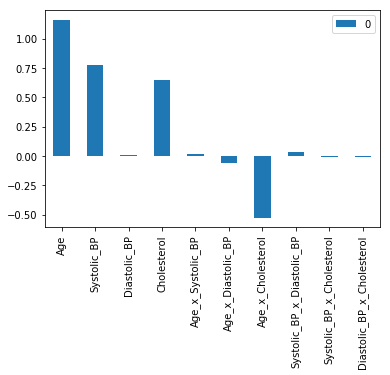

In [22]:
int_coeffs = pd.DataFrame(data = model_X_int.coef_, columns = X_train_int.columns)
int_coeffs.T.plot.bar();

You may notice that Age, Systolic_BP, and Cholesterol have a positive coefficient. This means that a higher value in these three features leads to a higher prediction probability for the disease. You also may notice that the interaction of Age x Cholesterol has a negative coefficient. This means that a higher value for the Age x Cholesterol product reduces the prediction probability for the disease.

To understand the effect of interaction terms, let's compare the output of the model we've trained on sample cases with and without the interaction.

In [23]:
index = index = 3432
case = X_train_int.iloc[index, :]
print(case)

Age                           2.502061
Systolic_BP                   1.713547
Diastolic_BP                  0.268265
Cholesterol                   2.146349
Age_x_Systolic_BP             4.287400
Age_x_Diastolic_BP            0.671216
Age_x_Cholesterol             5.370296
Systolic_BP_x_Diastolic_BP    0.459685
Systolic_BP_x_Cholesterol     3.677871
Diastolic_BP_x_Cholesterol    0.575791
Name: 5970, dtype: float64


We can see that they have above average Age and Cholesterol. We can now see what our original model would have output by zero-ing out the value for Cholesterol and Age.

In [24]:
new_case = case.copy(deep=True)
new_case.loc["Age_x_Cholesterol"] = 0
new_case

Age                           2.502061
Systolic_BP                   1.713547
Diastolic_BP                  0.268265
Cholesterol                   2.146349
Age_x_Systolic_BP             4.287400
Age_x_Diastolic_BP            0.671216
Age_x_Cholesterol             0.000000
Systolic_BP_x_Diastolic_BP    0.459685
Systolic_BP_x_Cholesterol     3.677871
Diastolic_BP_x_Cholesterol    0.575791
Name: 5970, dtype: float64

In [25]:
print(f"Output with interaction: \t{model_X_int.predict_proba([case.values])[:, 1][0]:.4f}")
print(f"Output without interaction: \t{model_X_int.predict_proba([new_case.values])[:, 1][0]:.4f}")

Output with interaction: 	0.9448
Output without interaction: 	0.9965


We see that the model is less confident in its prediction with the interaction term than without (the prediction value is lower when including the interaction term). With the interaction term, the model has adjusted for the fact that the effect of high cholesterol becomes less important for older patients compared to younger patients.